In [55]:
import numpy as np
import gc

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import (
    Dense,
    Flatten,
    Conv2D,
    MaxPooling2D,
    Dropout,
    Input,
    BatchNormalization,
    Concatenate,
    GlobalAveragePooling2D,
    Conv2DTranspose,
    concatenate,
)

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence, plot_model

from tensorflow.keras.preprocessing.image import (
    load_img,
    img_to_array,
    ImageDataGenerator,
)

from tensorflow.keras.datasets import mnist
import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow_addons as tfa

import pandas as pd
import matplotlib.pyplot as plt

import os

from sklearn.metrics import jaccard_score
from sklearn.model_selection import train_test_split

import cv2

from PIL import Image

from glob import glob
from pathlib import Path
from typing import Generator

import random

random_state = 123456
random.seed(random_state)

In [56]:
def smooth_data(data_frame, window_size=10):

    window = 2 * window_size + 1  
    return data_frame.rolling(window=window, min_periods=1, center=True).mean()

In [ ]:

def load_data(path: str = "../dataset") -> Generator[np.array, float, float]:
    csv_paths = glob(f"{path}/*.csv")
    #random.shuffle(csv_paths)
    
    for csv_path in csv_paths:
        csv_data = pd.read_csv(csv_path, header=None)
        csv_data.columns = ["id", "forward", "left"]
        
        csv_data = smooth_data(csv_data)
        
        image_paths = glob(f"{csv_path.removesuffix('.csv')}/*.jpg")
        #random.shuffle(image_paths)
        
        for image_path in image_paths:
            image_data = load_img(image_path)
            image_number = int(Path(image_path).name.removesuffix(".jpg"))
            row = csv_data[csv_data["id"]==image_number]
            if row.empty:
                continue
            yield image_data, row["forward"].values[0], row["left"].values[0]
        

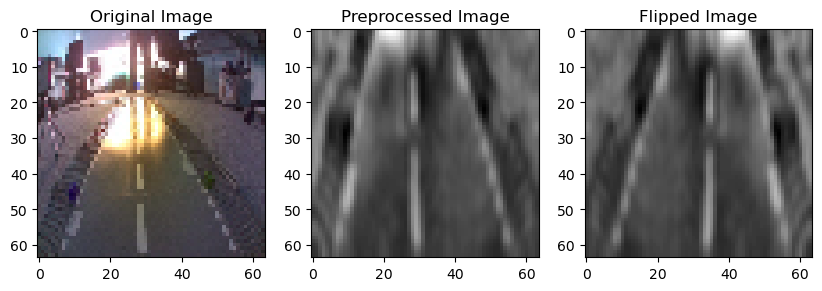

In [64]:
img_size = 64

img, _, _ = next(load_data())
img_preprocessed = img_to_array(img).astype(np.uint8)

img_og= cv2.resize(img_preprocessed, (img_size, img_size))

img_gray = cv2.cvtColor(img_og, cv2.COLOR_BGR2GRAY)
img_clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(img_gray)
img_blurred = cv2.GaussianBlur(img_clahe, (3, 3), 0)

img_crop = img_blurred[img_size//2:img_size, 0:img_size]
img_crop = cv2.resize(img_crop, (img_size, img_size))
    
img_preprocessed = img_crop

pil_preprocessed = Image.fromarray(img_preprocessed.astype(np.uint8), "L")

pil_flipped = pil_preprocessed.transpose(method=Image.FLIP_LEFT_RIGHT)

fig, ax = plt.subplots(1, 3, figsize=(10, 5))

ax[0].imshow(img_og)
ax[0].set_title("Original Image")
ax[1].imshow(pil_preprocessed, cmap='gray')
ax[1].set_title("Preprocessed Image")
ax[2].imshow(pil_flipped, cmap='gray')
ax[2].set_title("Flipped Image")
plt.show()


In [ ]:
def load_data_preprocess(path, image_size, batch_size, preprocess = True, augmentation = True):
    def preprocess(image):
        ...
    
    def augment(image, forward, left):
        ...
        
    data_loader = load_data(path)
    batch_images = []
    batch_labels = []

    for image, forward, left in data_loader:
        #image = cv2.resize(image, (image_size, image_size))
        #image = preprocess(image)
    
        batch_images.append(image)
        batch_labels.append([forward, left])

        if len(batch_images) == batch_size:
            yield np.array(batch_images), np.array(batch_labels)
            batch_images = []
            batch_labels = []
            
    if batch_images:
        yield np.array(batch_images), np.array(batch_labels)

In [59]:
image_size = 64
loader = load_data_preprocess("../dataset", image_size, 64, False, False)

OG type:  <class 'numpy.ndarray'>
New type:  <class 'numpy.ndarray'>
labels:  [0.46590909 0.        ]


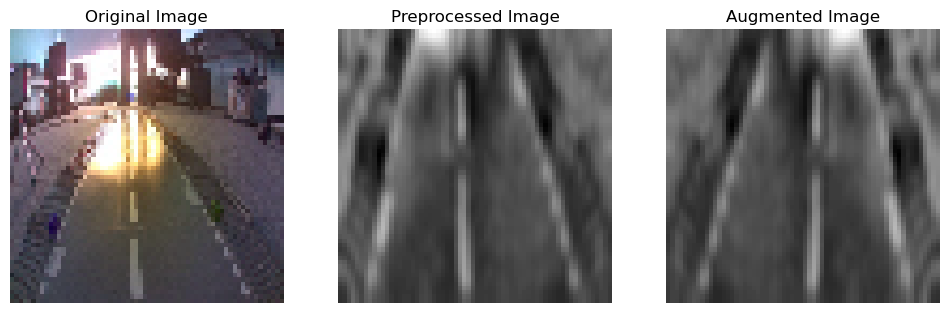

OG type:  <class 'numpy.ndarray'>
New type:  <class 'numpy.ndarray'>
labels:  [0.51458333 0.        ]


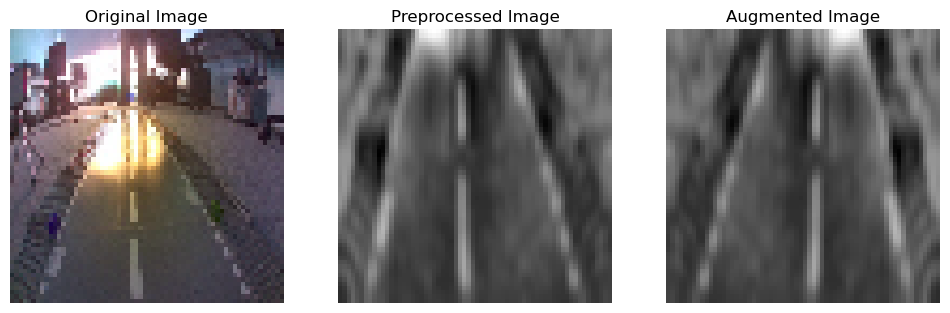

OG type:  <class 'numpy.ndarray'>
New type:  <class 'numpy.ndarray'>
labels:  [0.54276316 0.        ]


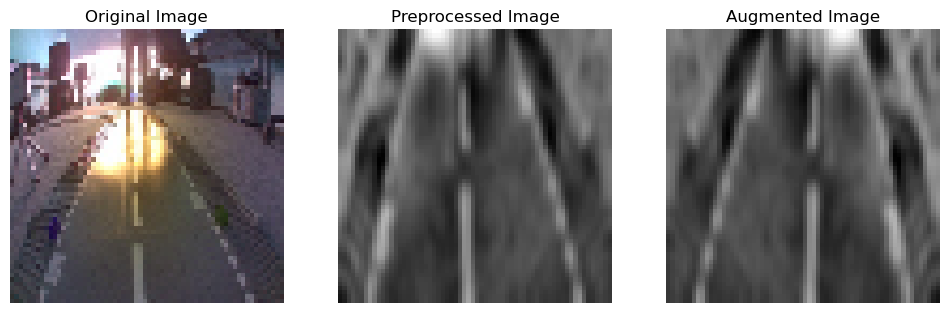

OG type:  <class 'numpy.ndarray'>
New type:  <class 'numpy.ndarray'>
labels:  [0.58184524 0.        ]


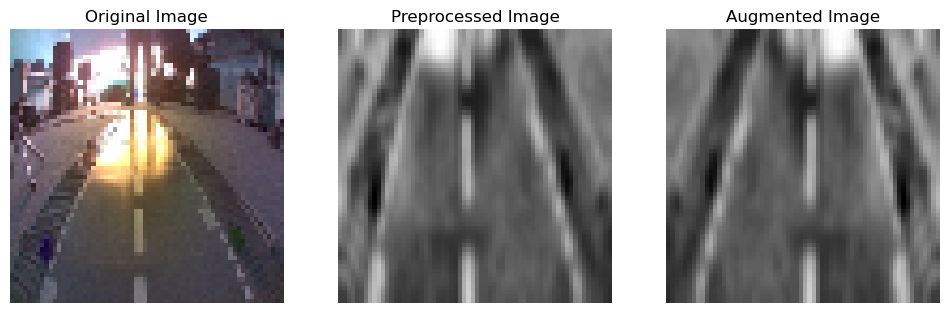

OG type:  <class 'numpy.ndarray'>
New type:  <class 'numpy.ndarray'>
labels:  [0.61495536 0.        ]


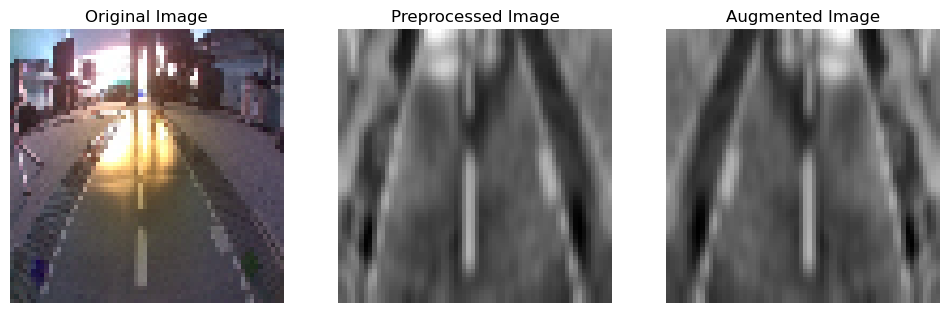

OG type:  <class 'numpy.ndarray'>
New type:  <class 'numpy.ndarray'>
labels:  [0.63653274 0.        ]


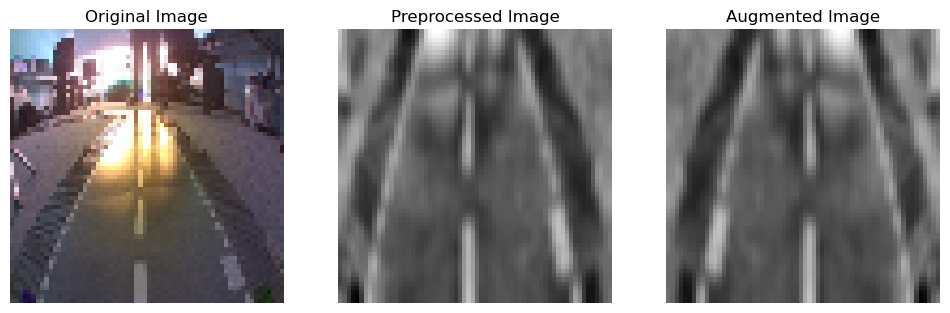

OG type:  <class 'numpy.ndarray'>
New type:  <class 'numpy.ndarray'>
labels:  [ 0.64769345 -0.04761905]


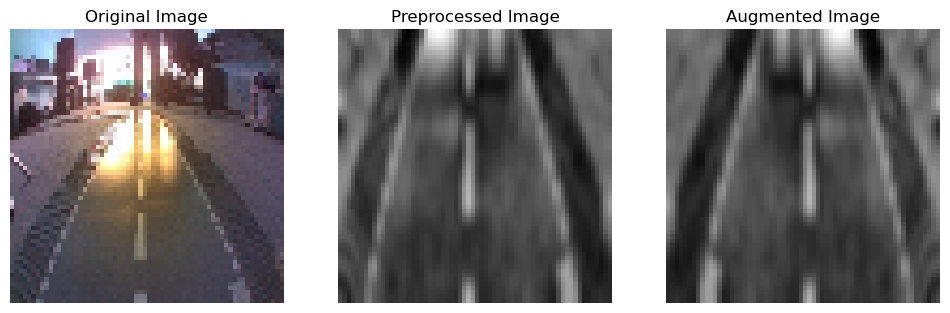

OG type:  <class 'numpy.ndarray'>
New type:  <class 'numpy.ndarray'>
labels:  [ 0.6484375  -0.04761905]


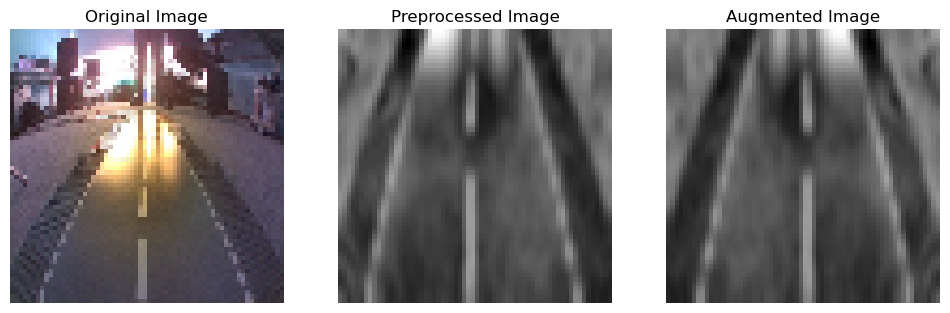

OG type:  <class 'numpy.ndarray'>
New type:  <class 'numpy.ndarray'>
labels:  [ 0.6484375  -0.04761905]


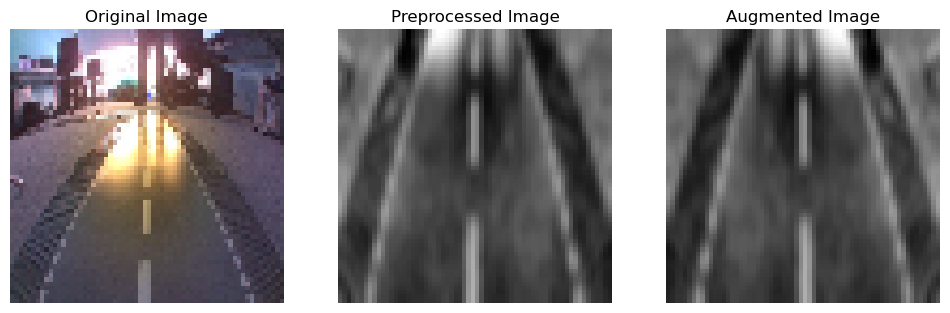

OG type:  <class 'numpy.ndarray'>
New type:  <class 'numpy.ndarray'>
labels:  [ 0.6484375 -0.0952381]


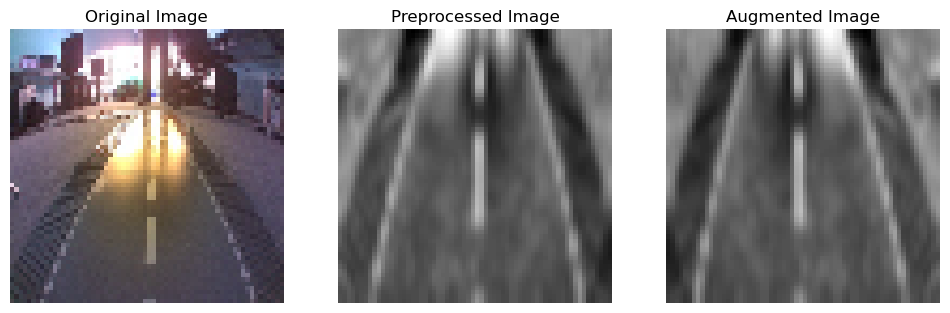

OG type:  <class 'numpy.ndarray'>
New type:  <class 'numpy.ndarray'>
labels:  [ 0.65811012 -0.0952381 ]


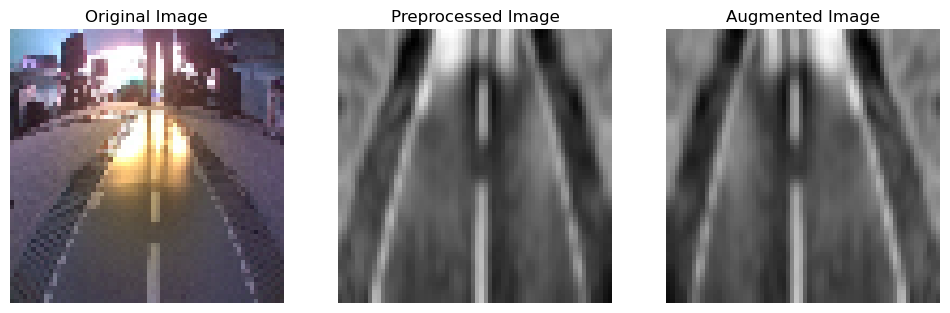

OG type:  <class 'numpy.ndarray'>
New type:  <class 'numpy.ndarray'>
labels:  [ 0.67782738 -0.0952381 ]


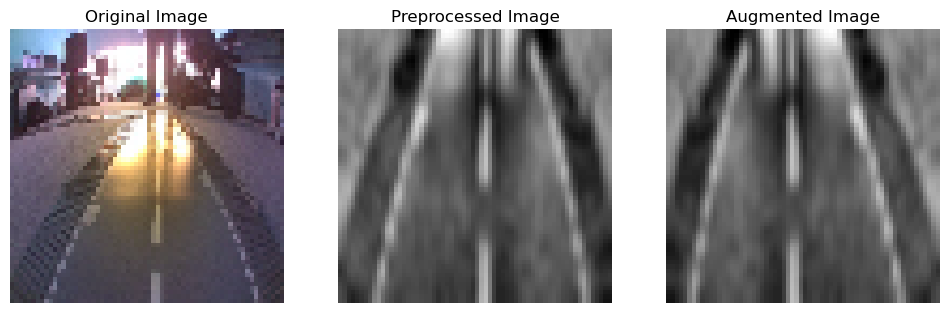

OG type:  <class 'numpy.ndarray'>
New type:  <class 'numpy.ndarray'>
labels:  [ 0.69419643 -0.0952381 ]


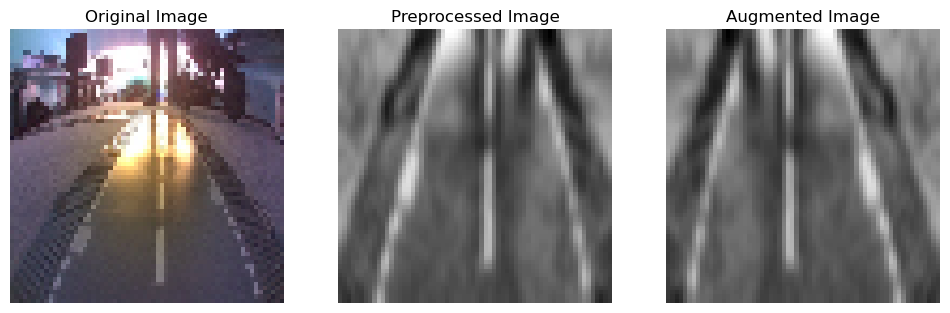

OG type:  <class 'numpy.ndarray'>
New type:  <class 'numpy.ndarray'>
labels:  [ 0.70758929 -0.0952381 ]


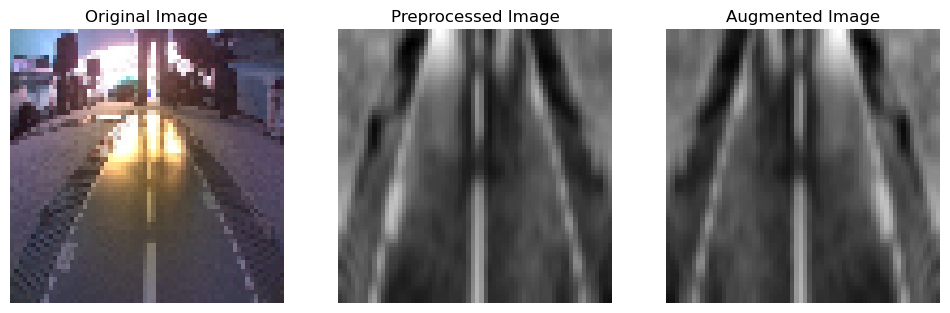

OG type:  <class 'numpy.ndarray'>
New type:  <class 'numpy.ndarray'>
labels:  [ 0.71875   -0.0952381]


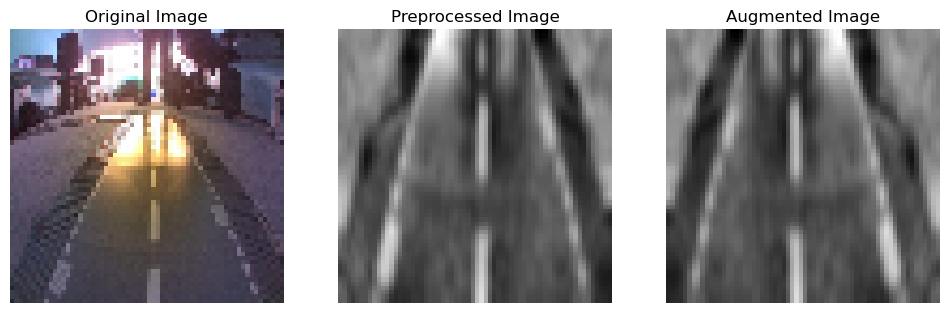

OG type:  <class 'numpy.ndarray'>
New type:  <class 'numpy.ndarray'>
labels:  [ 0.72842262 -0.0952381 ]


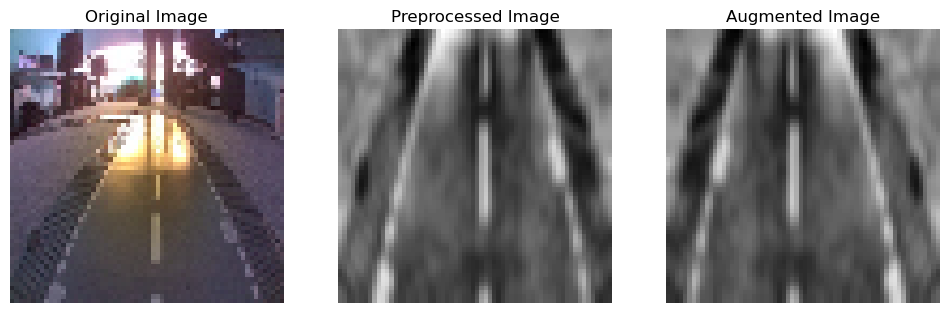

OG type:  <class 'numpy.ndarray'>
New type:  <class 'numpy.ndarray'>
labels:  [ 0.73809524 -0.0952381 ]


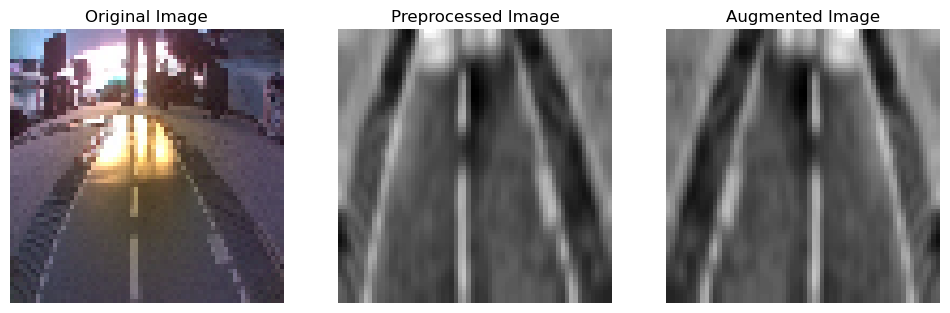

OG type:  <class 'numpy.ndarray'>
New type:  <class 'numpy.ndarray'>
labels:  [ 0.74553571 -0.0952381 ]


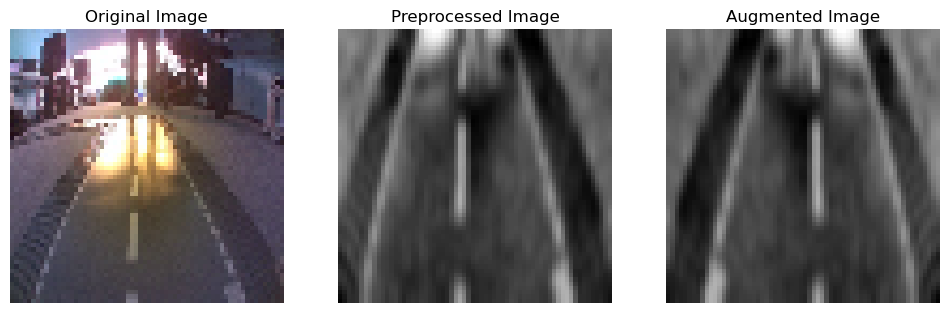

OG type:  <class 'numpy.ndarray'>
New type:  <class 'numpy.ndarray'>
labels:  [ 0.75297619 -0.0952381 ]


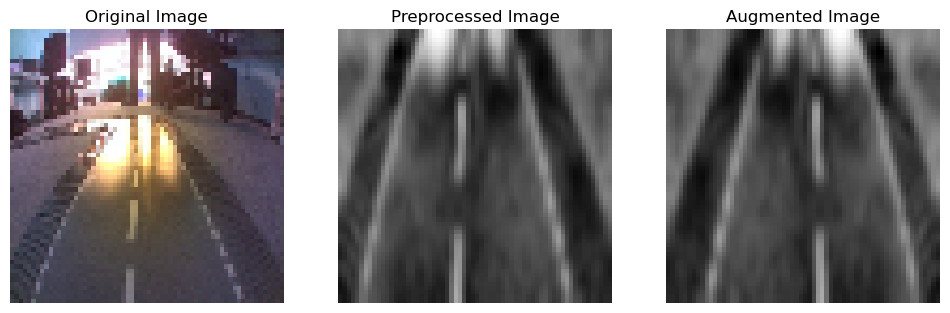

OG type:  <class 'numpy.ndarray'>
New type:  <class 'numpy.ndarray'>
labels:  [ 0.76041667 -0.0952381 ]


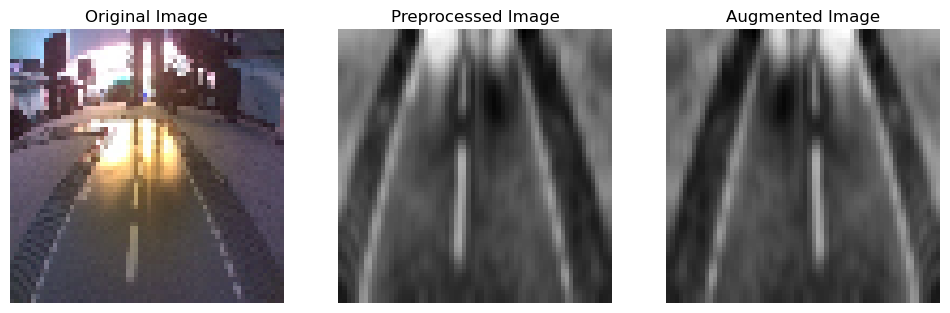

OG type:  <class 'numpy.ndarray'>
New type:  <class 'numpy.ndarray'>
labels:  [ 0.76785714 -0.04761905]


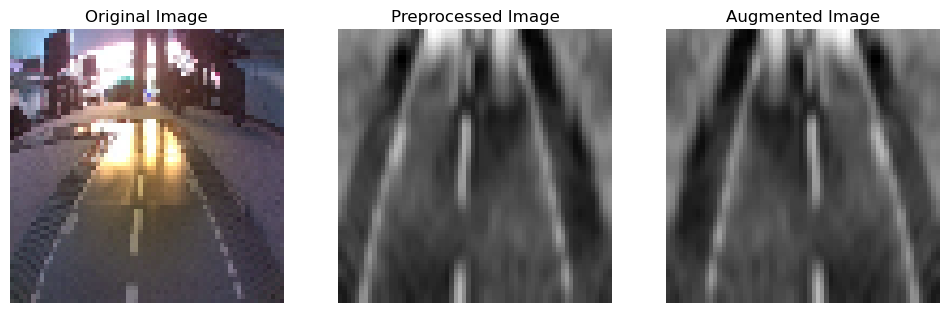

OG type:  <class 'numpy.ndarray'>
New type:  <class 'numpy.ndarray'>
labels:  [ 0.75558036 -0.04761905]


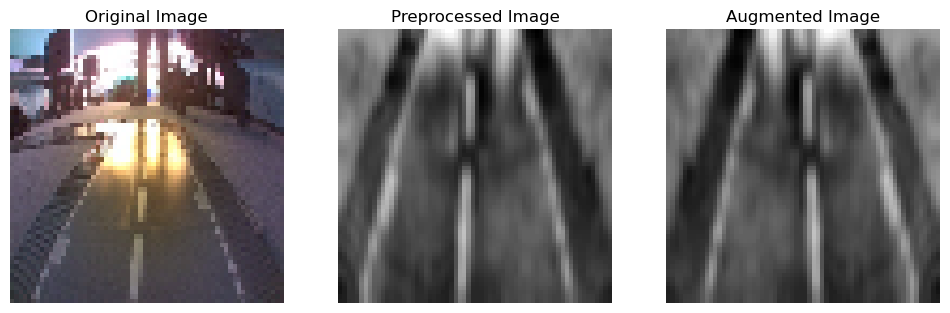

OG type:  <class 'numpy.ndarray'>
New type:  <class 'numpy.ndarray'>
labels:  [ 0.74404762 -0.05096726]


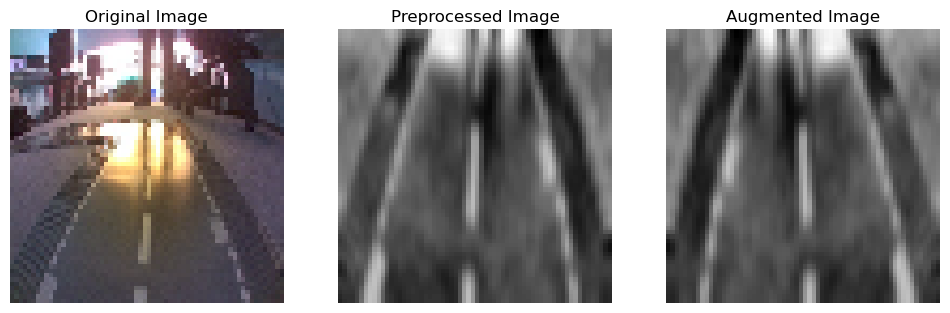

OG type:  <class 'numpy.ndarray'>
New type:  <class 'numpy.ndarray'>
labels:  [ 0.73735119 -0.09858631]


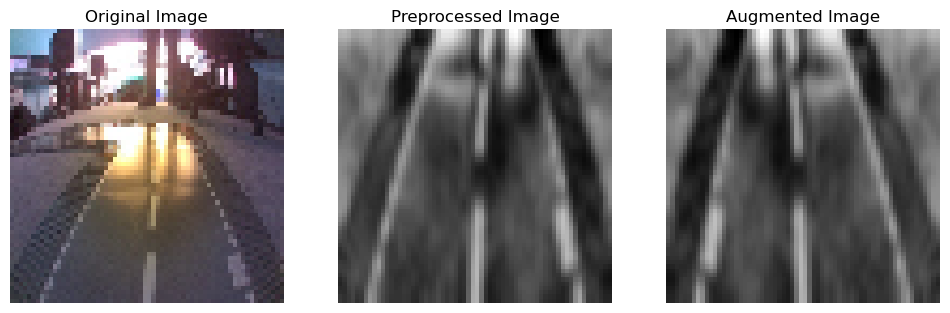

OG type:  <class 'numpy.ndarray'>
New type:  <class 'numpy.ndarray'>
labels:  [ 0.73028274 -0.09858631]


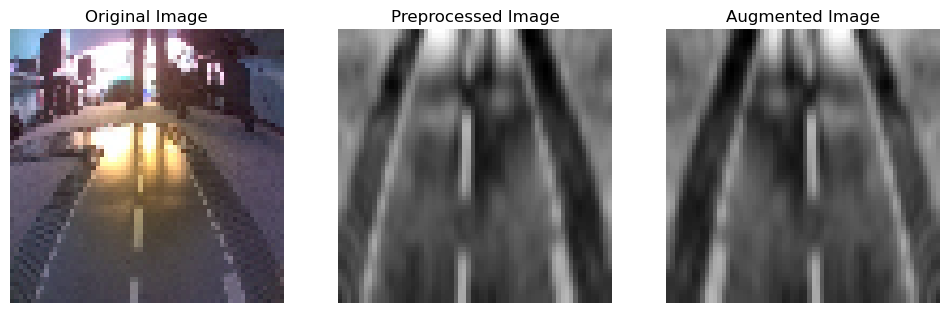

OG type:  <class 'numpy.ndarray'>
New type:  <class 'numpy.ndarray'>
labels:  [ 0.7250744  -0.09858631]


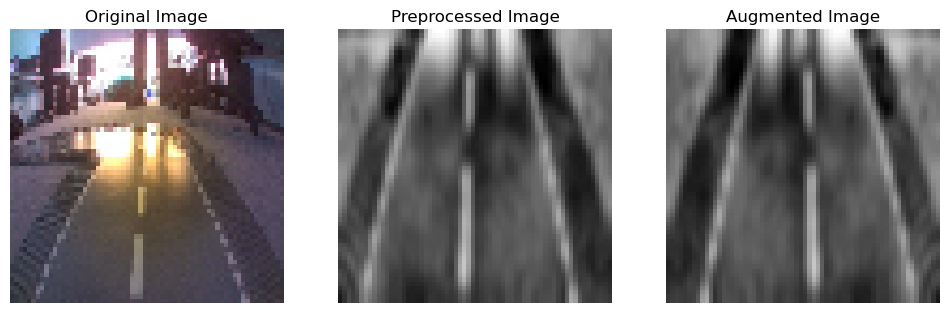

OG type:  <class 'numpy.ndarray'>
New type:  <class 'numpy.ndarray'>
labels:  [ 0.71986607 -0.09858631]


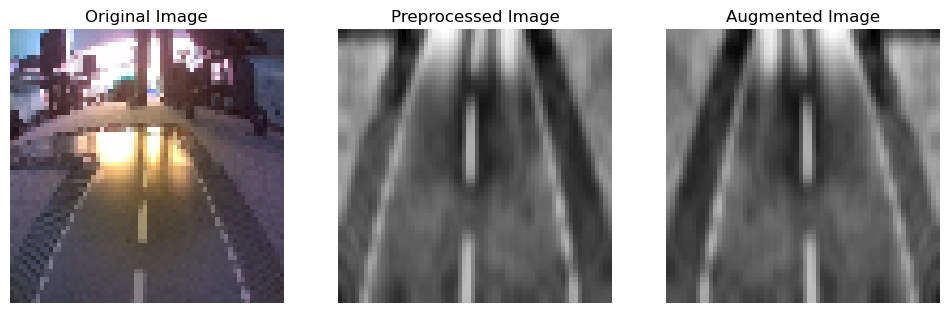

OG type:  <class 'numpy.ndarray'>
New type:  <class 'numpy.ndarray'>
labels:  [ 0.71465774 -0.09858631]


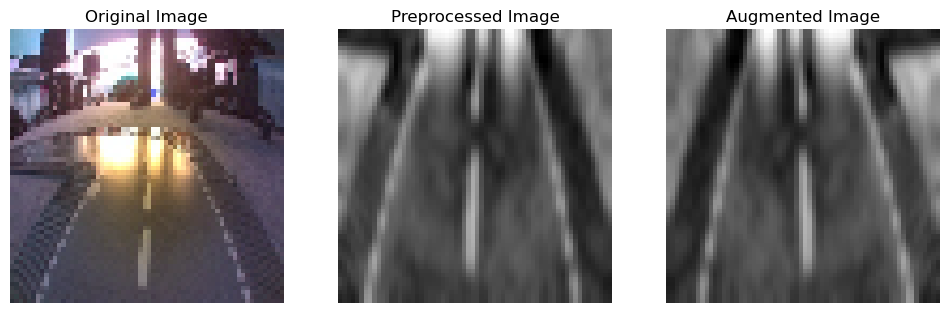

OG type:  <class 'numpy.ndarray'>
New type:  <class 'numpy.ndarray'>
labels:  [ 0.71056548 -0.05096726]


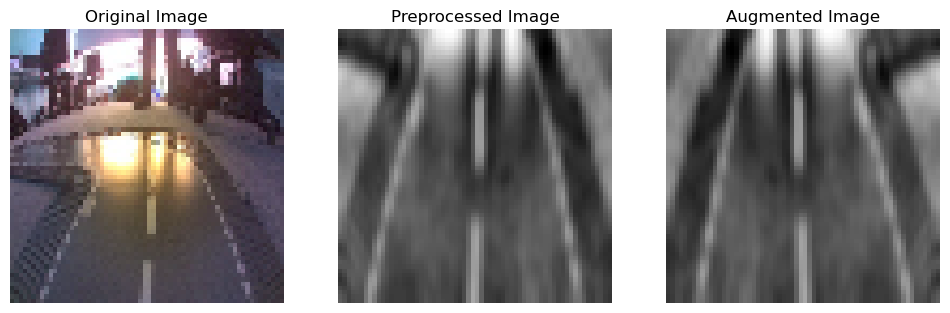

OG type:  <class 'numpy.ndarray'>
New type:  <class 'numpy.ndarray'>
labels:  [ 0.70572917 -0.00372024]


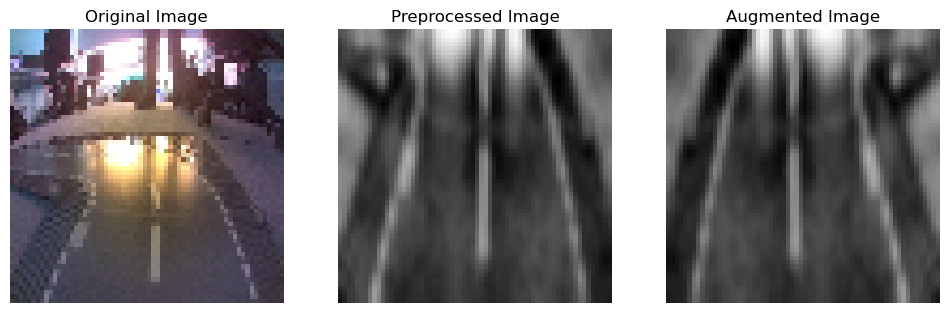

OG type:  <class 'numpy.ndarray'>
New type:  <class 'numpy.ndarray'>
labels:  [ 0.69828869 -0.00372024]


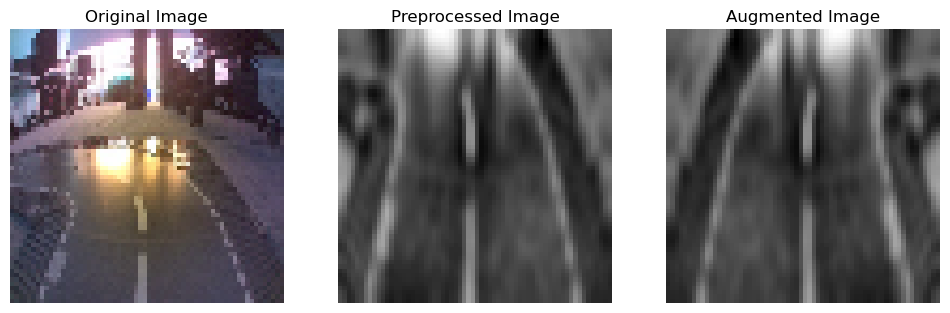

OG type:  <class 'numpy.ndarray'>
New type:  <class 'numpy.ndarray'>
labels:  [0.69084821 0.09077381]


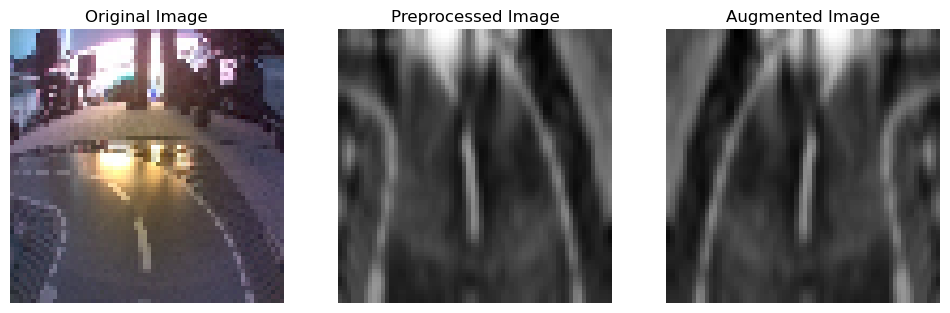

In [60]:
images, labels = next(loader)

for i in range(0, 64, 2):
    fig, ax = plt.subplots(1, 3, figsize=(12, 6))
    
    print("OG type: ", type(images[i]))
    image_content = images[i]
    
    image_content = cv2.cvtColor(image_content, cv2.COLOR_BGR2GRAY)
    img_clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)).apply(image_content)
    img_blurred = cv2.GaussianBlur(img_clahe, (3, 3), 0)
    
    img_crop = img_blurred[image_size//2:image_size, 0:image_size]
    img_crop = cv2.resize(img_crop, (image_size, image_size))
    
    img_preprocessed = img_crop
    
    img_augmented = cv2.flip(img_preprocessed, 1)
    
    print("New type: ", type(image_content))
    print("labels: ", labels[i])
    ax[0].imshow(images[i])
    ax[0].set_title("Original Image")
    ax[1].imshow(img_preprocessed, cmap="gray")
    ax[1].set_title("Preprocessed Image")
    ax[0].axis("off")
    ax[1].axis("off")
    
    ax[2].imshow(img_augmented, cmap="gray")
    ax[2].set_title("Augmented Image")
    ax[2].axis("off")
    plt.show()